In [1]:
#!pip install pyvista
%config Completer.use_jedi = False #for auto complete code

In [2]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

from flopy.export import vtk

print(sys.version)
print("flopy version: {}".format(flopy.__version__))

np.set_printoptions(precision=4, suppress=True)

sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
flopy version: 3.8.2


In [3]:
model_name = 'regional_model'
model_path = '../inputData/vtk_creation/model/'
exe_name = '../modflowExe/mf6.exe'

In [4]:
#load the regional model
sim = flopy.mf6.MFSimulation.load(model_name+'.nam',sim_ws=model_path,exe_name=exe_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package oc...
  loading solution package regional_model...


In [5]:
workspace = '../outputData/vtk_Creation/vtk_files/'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

In [6]:
gwf = sim.get_model()

In [7]:
gwf.get_package_list()

['DISV', 'IC', 'NPF', 'CHD_0', 'RIV_0', 'OC']

In [8]:
disv = gwf.get_package('DISV')

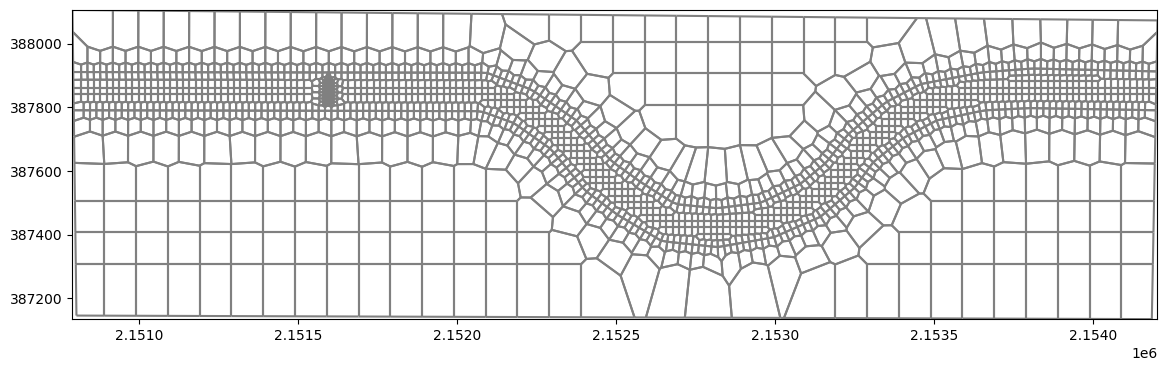

In [9]:
#plot aerial plot
fig, ax = plt.subplots(figsize=(14,6))
mapview = flopy.plot.PlotMapView(model=gwf)
linecollection = mapview.plot_grid()

In [10]:
model_output_dir = os.path.join(workspace, "model_output_test")

In [11]:
#gwf.export(model_output_dir, fmt="vtk")
#from flopy.export.vtk import export_model
#gwf.export(model_output_dir,fmt="vtk")
#export_model(gwf,model_output_dir)
#from flopy.export.vtk import Vtk
gwf.export(model_output_dir, fmt="vtk")


In [12]:
# get frf, fff, flf from the Cell Budget file (or SPDIS when using MF6)
from flopy.utils import postprocessing
import flopy.utils.binaryfile as bf
#spdis = postprocessing.get_specific_discharge((frf, fff, flf), ml)
model_ws = '../inputData/vtk_creation/model'
model_name = 'regional_model'

hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
#head = hds.get_data(totim=1.0)
#head[head==1e+30]=np.nan

cpth = os.path.join(model_ws, model_name+'.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision=hds.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)

spdis = postprocessing.get_specific_discharge(spd,gwf)

# import the HeadFile reader and read in the head file
from flopy.utils import HeadFile

head_file = os.path.join(model_path, model_name+".hds")
hds = HeadFile(head_file)

# create the vtk object and export heads
vtkobj = vtk.Vtk(gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_vector(spdis,name="spd")
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "regional_model_head.vtu"))

In [ ]:
import pyvista as pv
import os

# Load your VTK file
workspace = '../outputData/vtk_Creation/vtk_files/'
filename = os.path.join(workspace, "model_output_test", "regional_model_000000.vtk")

# Check if the file exists before attempting to read it
if not os.path.exists(filename):
    raise FileNotFoundError(f"The specified VTK file does not exist: {filename}")

reader = pv.get_reader(filename)
mesh = reader.read()

# Create the PyVista plotter
plotter = pv.Plotter(notebook=False)
plotter.add_text("This is a PyVista plotter window", font_size=15)
plotter.add_mesh(mesh.outline(), color='black', line_width=1)

# Initial slice of the mesh along the x-axis
initial_slice_position = (mesh.bounds[0] + mesh.bounds[1]) / 2
sliced_mesh = mesh.slice(normal='x', origin=(initial_slice_position, 0, 0))
slice_actor = plotter.add_mesh(sliced_mesh, show_scalar_bar=False, color="black", name='slice', style='wireframe')

# Set the camera position
plotter.set_focus(mesh.center)
plotter.reset_camera()
plotter.view_isometric()

# Add axis labels and bounding box with distances
plotter.show_bounds(
    grid='front',  # Display grid on the front face of the bounding box
    location='outer',
    all_edges=True,
    xlabel='X (ft)',
    ylabel='Y (ft)',
    zlabel='Z (ft)',
    ticks='both',
    show_xaxis=True,
    show_yaxis=True,
    show_zaxis=True,
    corner_factor=0.5,  # Adjust this for better visibility if needed
    font_size=8         # Smaller tick label font size
)

# Function to update the slice based on slider value
def update_slice(value):
    x_position = value
    # Update the sliced mesh
    new_sliced_mesh = mesh.slice(normal='x', origin=(x_position, 0, 0))
    # Update the data in the existing actor
    slice_actor.mapper.SetInputData(new_sliced_mesh)
    slice_actor.mapper.Update()
    plotter.render()

# Add a slider widget to control the slice position
plotter.add_slider_widget(
    callback=update_slice,
    rng=[mesh.bounds[0], mesh.bounds[1]],
    value=initial_slice_position,
    title='X Slice',
    pointa=(0.1, 0.1),  # Adjust the position of the slider if needed
    pointb=(0.9, 0.1),
)

# Show the plotter window
plotter.show()